<a href="https://colab.research.google.com/github/MRyo-ie/DataMining_Report3_Lv4_NLP_Models/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Report3

## Level 4: 文書分類せよ。


In [1]:
# 自分の Google Drive をマウント
# https://qiita.com/uni-3/items/201aaa2708260cc790b8#drive内のディレクトリをマウントする220180920
from google.colab import drive
import os
drive.mount('/content/gdrive')

#@markdown ### GitHubリポジトリをcloneして保存するパス （Google Drive上）
REPOSITORY_ROOT_DIR = 'Colab Notebooks/learning/old_nlp_techs' #@param {type: "string"}

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### << 実行手順 >>

1.  ↑ の、このボタンを押す　→　　![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)

1. ↖︎（左上）のどこかに「ドライブに保存」があるので、それをクリックして、  
  自分の Google Drive にこのファイルをコピーする。

1. ↑ の変数を設定する。
  - GitHub リポジトリをクローンする場所（GoogleDrive上の好きな場所）のパスを入力。

1. 実行。  
  - ↑で GoogleDrive をマウントするので、（英語の）指示に従って、  
    「ログイン」→「パスコードをコピー」→「四角枠に貼り付けしてEnter」

1. 後は勝手に実行してくれるはず

### 【準備】 パスなどの設定

In [2]:
REPOSITORY_URL = 'https://github.com/MRyo-ie/DataMining_Report3_Lv4_NLP_Models.git'
DATA_DL_URL = "https://www.rondhuit.com/download/ldcc-20140209.tar.gz"
GDRIVE_ROOT = '/content/gdrive/My Drive/'
REPO_PATH = os.path.join(GDRIVE_ROOT, REPOSITORY_ROOT_DIR, REPOSITORY_URL.split('/')[-1][:-4])

# よく使うパス
DATA_DIR = os.path.join(REPO_PATH, 'datas', 'articles_livedoor')
TMP_DIR = os.path.join(DATA_DIR, 'tmp')
FILE_PATH = os.path.join(DATA_DIR, 'tmp', DATA_DL_URL.split('/')[-1])

print("""
------------------------------------------------
<<<  パス一覧  >>>
REPO_PATH = {}

DATA_DL_URL = {}
DATA_DIR = {}
TMP_DIR = {}
FILE_PATH = {}
------------------------------------------------""".format(REPO_PATH, DATA_DL_URL, DATA_DIR, TMP_DIR, FILE_PATH))


------------------------------------------------
<<<  パス一覧  >>>
REPO_PATH = /content/gdrive/My Drive/Colab Notebooks/learning/old_nlp_techs/DataMining_Report3_Lv4_NLP_Models

DATA_DL_URL = https://www.rondhuit.com/download/ldcc-20140209.tar.gz
DATA_DIR = /content/gdrive/My Drive/Colab Notebooks/learning/old_nlp_techs/DataMining_Report3_Lv4_NLP_Models/datas/articles_livedoor
TMP_DIR = /content/gdrive/My Drive/Colab Notebooks/learning/old_nlp_techs/DataMining_Report3_Lv4_NLP_Models/datas/articles_livedoor/tmp
FILE_PATH = /content/gdrive/My Drive/Colab Notebooks/learning/old_nlp_techs/DataMining_Report3_Lv4_NLP_Models/datas/articles_livedoor/tmp/ldcc-20140209.tar.gz
------------------------------------------------


### 【準備】 GitHub clone

In [0]:
if not os.path.exists(REPO_PATH):
    repo_parent_path = os.path.join(GDRIVE_ROOT, REPOSITORY_ROOT_DIR)
    %cd  "$repo_parent_path"
    !git clone "$REPOSITORY_URL"  "$REPO_PATH"
    %cd "$REPO_PATH"
# else:
#     # pull -f （と同じ意味のコマンド）
#     %cd "$REPO_PATH"
#     # 最新の状態に更新（強制）
#     ! git fetch origin master
#     ! git reset --hard origin/master

### 【準備】 データ
今回は livedoor の記事データセットを使用。


In [0]:
import configparser
import glob
import os, sys
import pandas as pd
import subprocess
import tarfile
from tqdm import tqdm
from urllib.request import urlretrieve

#### DL& 読み込み

In [0]:
# !mkdir -p  "$TMP_DIR"
# %cd  "$TMP_DIR"

# if not os.path.exists(FILE_PATH):
#     ! wget  "$DATA_DL_URL"
# # 時間かかる。
# !tar  -zxvf   'ldcc-20140209.tar.gz'
# !ls

In [6]:
categories = [ 
    name for name 
    in os.listdir( os.path.join(TMP_DIR, "text") ) 
    if os.path.isdir( os.path.join(TMP_DIR, "text", name) ) ]

categories = sorted(categories)
categories

['dokujo-tsushin',
 'it-life-hack',
 'kaden-channel',
 'livedoor-homme',
 'movie-enter',
 'peachy',
 'smax',
 'sports-watch',
 'topic-news']

#### データの抽出・整備



- ラベル（記事の種類）一覧

In [7]:
table = str.maketrans({
    '\n': '',
    '\t': '　',
    '\r': '',
})

def extract_txt(filename):
    with open(filename) as text_file:
        # 0: URL, 1: timestamp
        text = text_file.readlines()[2:]
        text = [sentence.strip() for sentence in text]
        text = list(filter(lambda line: line != '', text))
        return ''.join(text)

%cd  "$TMP_DIR/"

/content/gdrive/My Drive/Colab Notebooks/learning/old_nlp_techs/DataMining_Report3_Lv4_NLP_Models/datas/articles_livedoor/tmp


In [8]:
%cd  "$TMP_DIR/"

# 割と時間かかる。（ので、データを保存したら、２回目以降は実行しないようにした）
if not os.path.exists(os.path.join(TMP_DIR, 'extracts', "train.tsv")):
    all_text = []
    all_label = []
    for cat in tqdm(categories):
        files = glob.glob(os.path.join("text", cat, "{}*.txt".format(cat)))
        files = sorted(files)
        body = [ extract_txt(elem).translate(table) for elem in files ]
        label = [cat] * len(body)
        
        all_text.extend(body)
        all_label.extend(label)

    df = pd.DataFrame({'text' : all_text, 'label' : all_label})
    print(df.head())
    df = df.sample(frac=1, random_state=23).reset_index(drop=True)
    print(df.head())

/content/gdrive/My Drive/Colab Notebooks/learning/old_nlp_techs/DataMining_Report3_Lv4_NLP_Models/datas/articles_livedoor/tmp


#### ファイルに保存 (機械学習モデル用)

In [0]:
## Sentence Piece
SP_MODEL_DIR = os.path.join(REPO_PATH, 'models', 'Tokenizer', 'SentencePiece')

extract_dir = os.path.join(TMP_DIR, 'extracts')
SentencePiece_train_dir = os.path.join(SP_MODEL_DIR, 'tmp')
if not os.path.exists(os.path.join(SP_MODEL_DIR, 'tmp')):
    ! mkdir  "$extract_dir"
    ! mkdir  "$SentencePiece_train_dir"

dpaths = {
    'test' : os.path.join(extract_dir, "test.tsv"),
    'val' : os.path.join(extract_dir, "val.tsv"),
    'train' : os.path.join(extract_dir, "train.tsv"),
}

In [0]:
if not os.path.exists(os.path.join(SentencePiece_train_dir, "train.txt")):
    # Sentence Piece 用の raw text データを作成
    df.to_csv( os.path.join(SentencePiece_train_dir, "train.txt"), sep=' ', index=False, header=False, columns=['text'] )
    ! head -3  "$SentencePiece_train_dir"/train.txt

if not os.path.exists(dpaths['train']):
    # 言語モデル用の train, test, dev データファイルを作成
    df[:len(df) // 5].to_csv( dpaths['test'], sep='\t', index=False )
    df[len(df) // 5:len(df)*2 // 5].to_csv( dpaths['val'], sep='\t', index=False )
    df[len(df)*2 // 5:].to_csv( dpaths['train'], sep='\t', index=False )
    P = dpaths['test']
    ! head -3  "$P"

### Layer1 : 分かち書き（Tokenize）
- 今回は **Sentence Piece** を使ってみる。  
  https://www.madopro.net/entry/sentencepiece_rnn_lm
- 一番上の２つを実行すれば、あとはここからでOK

In [0]:
# モデル関連のパス
## Sentence Piece
SP_MODEL_DIR = os.path.join(REPO_PATH, 'models', 'Tokenizer', 'SentencePiece')
LANGUAGE_ROOT_DIR = os.path.join(REPO_PATH, 'models', 'LanguageModel')

extract_dir = os.path.join(TMP_DIR, 'extracts')
SentencePiece_train_dir = os.path.join(SP_MODEL_DIR, 'tmp')

dpaths = {
    'test' : os.path.join(extract_dir, "test.tsv"),
    'val' : os.path.join(extract_dir, "val.tsv"),
    'train' : os.path.join(extract_dir, "train.tsv"),
}

In [12]:
! pip install sentencepiece

In [13]:
%cd  "$SP_MODEL_DIR"
!echo '[Info] Sentence Piece の学習を開始します。'
if not os.path.exists('model'):
    ! mkdir  'model'

# SentencePiece を学習する：モデルを作る。
import sentencepiece as spm
# 5分くらいかかる。（一度作ったら飛ばすように設定済み。 Setnence Piece のモデルファイルがあるかで判定。（m.model））
if not os.path.exists('model/m.model'):
    spm.SentencePieceTrainer.Train('--input=tmp/train.txt --model_prefix=model/m --vocab_size=8000')
print('[Info] 終了！')

/content/gdrive/My Drive/Colab Notebooks/learning/old_nlp_techs/DataMining_Report3_Lv4_NLP_Models/models/Tokenizer/SentencePiece
[Info] Sentence Piece の学習を開始します。
[Info] 終了！


In [14]:
# 学習したSentencePieceモデルを読み込む
sp = spm.SentencePieceProcessor()
sp.Load('model/m.model')
# こんな感じで 分かち書きできる。
print( sp.EncodeAsPieces('吾輩は猫である') )

['▁', '吾', '輩', 'は', '猫', 'である']


### Layer2 : Embedding
- 今回は、BoW+TF-IDF、共起行列、XLNet の予定。

#### 事前処理
- Token（単語など） に ID を振る。

In [15]:
sentences = []
with open('tmp/train.txt', 'r', encoding='utf-8') as f:
    sentences = f.read().split('\n')
print(sentences[7])

"ケーブルいらずのスマホバッテリ！情報満載の1日を振り返る【ITフラッシュバック】ThinkPadをNECで生産するニュースからケーブルいらずのバッテリー、その場で動画を共有するテクニック、315gの最軽量スキャナ、孫正義氏のTwitterまで、様々な記事が掲載された。情報満載の1日を振り返ってみよう。■ThinkPadをNECで生産へ 2012年秋より日本で試験生産【デジ通】レノボとNECパーソナルコンピュータは2011年7月より、NECレノボ・ジャパングループの元で運営されている。それから1年が経過し、ユーザーの目に見える部分では、レノボのサポートサービスをNECに委託し、レノボのIdeaCenterにNECのTV技術を用いた製品が発表されるなど、いつかの点でその成果が出始めている。さらに、一部の個人ユーザーに人気のThinkPadを、NECの米沢事業所で試験生産することを発表した。■Dockコネクターに直挿し！iPhoneやiPadにケーブルいらずのバッテリー【イケショップのレア物】今回紹介する「Universal PowerBank 6000 for Smartphone/Tablet」は、これ1台でかなり対応できるスグレモノのモバイルバッテリーなのである。■iPhoneで撮った動画を仲間で共有！その場で動画を共有するテクニック【知っ得！虎の巻】iPhoneを使えば、手軽に動画を撮影できる。プライベートシーンなら、家族やペットの撮影を楽しめる。ビジネスシーンなら、現場の様子を撮影してわかりやすく報告できる。もし、急ぎの報告が必要なら、いったんパソコンに取り込んでサーバーにアップするより、そのままYouTubeにアップして限定公開してみてはいかがだろう。■315gの最軽量スキャナも登場！PCレスでスキャンデータを活用できる「ADS-2500W」スマートフォンやタブレット端末などの普及やクラウドサービスの利用拡大などから、書類をデータ化して活用する機会が増え、ドキュメントスキャナーのニーズが高まっている。そうしたニーズにこたえるために、ブラザーが新製品を投入する。■電子ブックリーダー「kobo Touch」の実機が見られる！楽天が大手書店と連携した理由「お得に購入できる裏技あり！楽天の書籍端末が凄い5つの理由」でお伝えしたように、楽天の電子ブックリーダー「kob

In [16]:
%cd  "$LANGUAGE_ROOT_DIR"

import pre
from tqdm import tqdm

###  data_w2i を作る。  ###
tknzd_all_sentences = []   # Token化した文書を一時的に保存（共起行列で利用）
token_set = set()
for s in tqdm(sentences):
    tknd_s = sp.EncodeAsPieces(s)  #=> ['▁', '吾', '輩', 'は', '猫', 'である']
    tknzd_all_sentences.append(tknd_s)
    token_set = token_set | set(tknd_s)   # Token の集合（set） を作成。（set は、dict のkeyだけ版）
# 全単語(Token) に id を割り当てた dict を作る。
data_w2i = pre.identify_some_tokens(token_set)

  0%|          | 0/7368 [00:00<?, ?it/s]

/content/gdrive/My Drive/Colab Notebooks/learning/old_nlp_techs/DataMining_Report3_Lv4_NLP_Models/models/LanguageModel


100%|██████████| 7368/7368 [00:09<00:00, 783.55it/s]


#### BoW

In [0]:
from Bag_of_Words import BoW

# 文（章）の list を渡すと、それらを BoW に変換した 文ベクトル (np.array) を返す。
bow = BoW(data_w2i)
def build_BoW_vecs(raw_sentences, data_w2i):
    print('[Info] Embedding中...')
    tknzd_sentences = [sp.EncodeAsPieces(s) for s in raw_sentences]
    return np.array([bow.embed_BoW(tknz_s) for tknz_s in tknzd_sentences])

#### co-matrix
- 文書中に現れた全単語の単語ベクトルを足し合わせ、総単語数で割る

In [18]:
from Co_Matrix import CoMatrix

# 文（章）の list を渡すと、それらを Co-Matrix に変換した 文ベクトル (np.array) を返す。
# word2id を元に、共起行列を作る。（全文を読み込む行うので、最初の１回のみ）
cmat = CoMatrix(data_w2i, tknzd_all_sentences, window_size=2)
print(cmat.co_matrix.shape)
def build_CoMatrix_vecs(raw_sentences, data_w2i):
    print('[Info] Embedding中...')
    tknzd_sentences = [sp.EncodeAsPieces(s) for s in raw_sentences]
    # 共起行列を元に、入力文（章）をベクトル化
    return np.array([cmat.embed_co_marrix(tknz_s) for tknz_s in tqdm(tknzd_sentences)])

100%|██████████| 7368/7368 [01:13<00:00, 100.03it/s]

(9046, 9046)


### Layer3 : 分類モデル
- 今回は、SVM で行う。

In [0]:
#@title Embedding Layer のアルゴリズムを選ぶ。
Embed_layer = "BoW"  #@param ['BoW', 'co-matrix', 'XLNet']

In [0]:
extract_dir = os.path.join(TMP_DIR, 'extracts')
dpaths = {
    'test' : os.path.join(extract_dir, "test.tsv"),
    'val' : os.path.join(extract_dir, "val.tsv"),
    'train' : os.path.join(extract_dir, "train.tsv"),
}

# P = dpaths['test']
# ! head -3  "$P"

#### train


##### データ読み込み

In [0]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

###  train.tsv から データを読み込み  ###
def get_datas(mode):
    df = pd.read_csv(dpaths[mode], sep='\t')
    return df['text'].values, df['label'].values

In [40]:
# 読み込み
raw_datas, raw_labels = get_datas('train')
print(type(raw_datas), len(raw_labels))

# データをシャッフル
print(raw_labels, "    DataNum: ", len(raw_datas))
raw_datas, raw_labels = resample(raw_datas, raw_labels, n_samples=len(raw_labels))
print(raw_labels, "    DataNum: ", len(raw_datas), )

<class 'numpy.ndarray'> 4421
['movie-enter' 'movie-enter' 'kaden-channel' ... 'it-life-hack' 'smax'
 'dokujo-tsushin']     DataNum:  4421
['sports-watch' 'movie-enter' 'peachy' ... 'it-life-hack' 'peachy'
 'peachy']     DataNum:  4421


In [41]:
###  ラベルを数値化  ###
label_list = [ 
    name for name 
    in os.listdir( os.path.join(TMP_DIR, "text") ) 
    if os.path.isdir( os.path.join(TMP_DIR, "text", name) ) ]

# ラベルリストに ID を付与する
label_w2i = pre.identify_some_tokens(label_list)
print(label_w2i)

{'dokujo-tsushin': 0, 'livedoor-homme': 1, 'kaden-channel': 2, 'smax': 3, 'topic-news': 4, 'peachy': 5, 'movie-enter': 6, 'it-life-hack': 7, 'sports-watch': 8}


##### Embedding

In [0]:
from sklearn import preprocessing

# Embedding
# 生の文（章）から、文（章）ベクトルに変換する。
def embed_datas(raw_datas, data_w2i:dict, is_normrize=True):
    datas = None
    if Embed_layer == 'BoW':
        datas = build_BoW_vecs(raw_datas, data_w2i)
    if Embed_layer == 'co-matrix':
        datas = build_CoMatrix_vecs(raw_datas, data_w2i)
        # is_normrize=False

    if is_normrize:
        # 正規化する（オプション）
        datas = normalize_vec(datas)
    print('[Info] 完了！')
    return datas

# 正規化 （SVMが収束しないので...）
def normalize_vec(vec):
    # 正規化、標準化 ライブラリ （https://note.nkmk.me/python-list-ndarray-dataframe-normalize-standardize/）
    mm = preprocessing.MinMaxScaler()
    return mm.fit_transform(vec)

In [43]:
%%time
# データを Embedding
datas = embed_datas(raw_datas, data_w2i)
print(datas, '\nshape : ', datas.shape)

[Info] Embedding中...
[Info] 完了！
[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.5 0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]] 
shape :  (4421, 9046)
CPU times: user 6.12 s, sys: 408 ms, total: 6.53 s
Wall time: 6.55 s


In [0]:
def conv_labels(raw_labels, label_w2i:dict):
    return np.array([label_w2i[w] for w in raw_labels])

In [45]:
# ラベルを ID化
labels = conv_labels(raw_labels, label_w2i)
print(labels, '\nshape : ', labels.shape)

[8 6 5 ... 7 5 5] 
shape :  (4421,)


##### 学習

In [0]:
##  パラメータ関係  ##
from sklearn.svm import LinearSVC
# SVC のハイパーパラメータ
svc = LinearSVC(max_iter=10000)

In [47]:
%%time
# Train
svc.fit(datas, labels)

CPU times: user 7.25 s, sys: 3.79 ms, total: 7.26 s
Wall time: 7.27 s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

#### Predict

##### データ読み込み

In [48]:
###  test.tsv から データを読み込み  ###
raw_datas, raw_labels = get_datas('test')
print(type(raw_datas), len(raw_labels))

# データをシャッフル
print(raw_labels, "    DataNum: ", len(raw_datas))
raw_datas, raw_labels = resample(raw_datas, raw_labels, n_samples=len(raw_labels))
print(raw_labels, "    DataNum: ", len(raw_datas), )

<class 'numpy.ndarray'> 1473
['sports-watch' 'kaden-channel' 'peachy' ... 'peachy' 'movie-enter'
 'movie-enter']     DataNum:  1473
['movie-enter' 'dokujo-tsushin' 'sports-watch' ... 'it-life-hack'
 'sports-watch' 'dokujo-tsushin']     DataNum:  1473


##### Embedding

In [49]:
datas_pred = embed_datas(raw_datas, data_w2i)
print(datas_pred, '\nshape : ', datas_pred.shape)

[Info] Embedding中...
[Info] 完了！
[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.25 0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]] 
shape :  (1473, 9046)


In [50]:
# ラベルを変換
labels_pred = conv_labels(raw_labels, label_w2i)
print(labels_pred, '\nshape : ', labels_pred.shape)

[6 0 8 ... 7 8 0] 
shape :  (1473,)


##### 予測

In [51]:
%%time
# Predict
prediction = svc.predict(datas_pred)

CPU times: user 65.3 ms, sys: 17 ms, total: 82.3 ms
Wall time: 58.1 ms


#### 結果 （混同行列グラフ化）

In [52]:
RESULRT_DIR = os.path.join(DATA_DIR, 'results')
!mkdir -p "$RESULRT_DIR"
%cd  "$RESULRT_DIR"

/content/gdrive/My Drive/Colab Notebooks/learning/old_nlp_techs/DataMining_Report3_Lv4_NLP_Models/datas/articles_livedoor/results


In [0]:
import matplotlib
matplotlib.use('Agg')
from matplotlib import pylab
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import glob
from sklearn.metrics import confusion_matrix


def normalisation(cm):
    new_cm = []
    for line in cm:
        sum_val = sum(line)
        new_array = [float(num)/float(sum_val) for num in line]
        new_cm.append(new_array)
    return new_cm

def plot_confusion_matrix(cm, name_list_org, title):
    name_list = list(map(lambda x: x.replace('_', '\n'), name_list_org))
    print(name_list)
    df = pd.DataFrame(cm, index=name_list, columns=name_list) #データフレーム化

    plt.clf()
    plt.cla()
    fig, ax = plt.subplots(figsize=(12, 9)) 
    print('df : {}'.format(df))
    sns.heatmap(df, square=True, cmap='Blues', vmin=0, vmax=1.0, annot=True,)
    pylab.title(title)
    pylab.xlabel('Predict class')
    pylab.ylabel('True class')

    filename = title + "_reslt.png"
    plt.savefig(filename)
    #plt.close()

[[0.9053254437869822, 0.011834319526627219, 0.011834319526627219, 0.0, 0.0, 0.0650887573964497, 0.0, 0.0, 0.005917159763313609], [0.0, 0.8604651162790697, 0.023255813953488372, 0.0, 0.0, 0.08139534883720931, 0.03488372093023256, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.024691358024691357, 0.0, 0.9444444444444444, 0.0, 0.0, 0.0, 0.030864197530864196], [0.024844720496894408, 0.037267080745341616, 0.006211180124223602, 0.0, 0.012422360248447204, 0.906832298136646, 0.012422360248447204, 0.0, 0.0], [0.018867924528301886, 0.0, 0.0, 0.0, 0.0, 0.012578616352201259, 0.9685534591194969, 0.0, 0.0], [0.005649717514124294, 0.011299435028248588, 0.02824858757062147, 0.0, 0.0, 0.0, 0.0, 0.9548022598870056, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]
['dokujo-tsushin', 'livedoor-homme', 'kaden-channel', 'smax', 'topic-news', 'peachy', 'movie-enter', 'it-life-hack', 'sports-watch']
df :                 dokujo-tsushin 

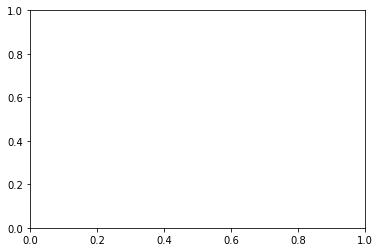

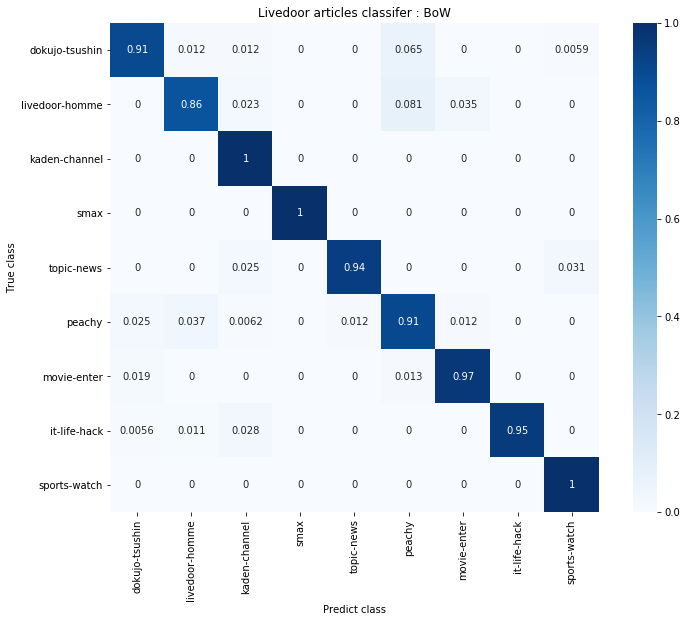

In [54]:
# 混同行列（図）で、結果を出力
cm = confusion_matrix(labels_pred, prediction)
print(normalisation(cm))
plot_confusion_matrix(normalisation(cm), label_list, "Livedoor articles classifer : "+Embed_layer)

### その他